Montamos google drive


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Intalamos librerias que no estan instaladas




In [44]:
!pip install tensorflow_addons
!pip install stockstats

Importamos librerias


In [46]:
import numpy as np 
from numpy import newaxis
import pandas as pd 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.models import Sequential
from keras import optimizers
from keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates 
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K
from stockstats import StockDataFrame
from keras import regularizers

Creamos que usaremos


In [47]:
def dejarPredictores(data, predictores, valor): #metodo para dejar los predictores y el valor a predecir solamente
  return data[predictores + [valor]] 
def dibujarGraficaTemporal(data , valor): #metodo para plotear
  data[valor].plot() 
def dividirTestTrain(data, porcentaje = 0.9): #metodo para splitear entre test y train
    row = round(porcentaje * data.shape[0])
    train = data[:row]
    test = data[row:]
    return train,test

def cargarDatos(ruta, valor, fecha, len_x, len_y, variablesAPredecir, predictores, division = 0.9): #metodo para cargar los datos
  #carga de datos
  data = pd.read_csv(ruta,index_col=fecha, parse_dates=[fecha]) #leemos los datos con la fecha
  print("dataset original")
  print(data.head())
  dibujarGraficaTemporal(data,valor) #dibujamos la grafica

  #preparacion y division de datos
  data2 = dejarPredictores(data, predictores, valor) #dejamos los predictores
  print("dataset con predictores")
  print(data2.head())

  #separamos entre x e y 
  y = dejarPredictores(data, variablesAPredecir, valor)
  print("Y head") 
  print(y.head())
  x = dejarPredictores(data, predictores, valor)
  print("X head") 
  print(x.head())

  #preparamos la separacion de los datos 100 -> 1
  data3x = []
  data3y = []
  maximosX = x.max(axis = 0)
  minimosX = x.min(axis = 0)
  maximosY = y.max(axis = 0)
  minimosY = y.min(axis = 0)
  mediaX = x.mean(axis = 0)
  mediaY = y.mean(axis = 0)
  x = (x - mediaX)/(maximosX - minimosX)
  y = (y - mediaY)/(maximosY - minimosY)
  for i in range(data2.shape[0] - (len_x + len_y)): #hacemos la normalizacion por slot y añadimos los slots a sus respectivas listas
    data3x.append(x[i : i + len_x])
    data3y.append(y[i :  i + len_x + len_y])
    data3y[i] = data3y[i][len_x : len_x + len_y]
  
  #convierto a np array
  data3x = np.array(data3x)
  data3y = np.array(data3y)
  print("x shape",data3x.shape)
  print("y shape",data3y.shape)

  #separo entre test y train
  row = round(division * data3x.shape[0])
  x_train = data3x[:row,] 
  y_train = data3y[:row,]
  y_train = y_train.squeeze()
  x_test = data3x[row:,]
  y_test = data3y[row:,]
  y_test = y_test.squeeze() #quito ceros de shape np array
  print("x train shape",x_train.shape)
  print("y train shape",y_train.shape)
  print("x test shape",x_test.shape)
  print("y test shape",y_test.shape)
  return data, x_train , y_train , x_test, y_test

Ejecuto el metodo anteriro y creo las variables glovales que voy a utilizar en el codigo


dataset original
                 high    low       open  ...      trix    change          vr
Date                                     ...                                
2006-11-13  17.870001  17.76  17.830000  ...  0.277565 -0.056276  187.897659
2006-11-14  17.940001  17.75  17.900000  ...  0.289115  0.900900  206.172072
2006-11-15  17.910000  17.77  17.790001  ...  0.297471 -0.390623  174.617213
2006-11-16  17.879999  17.75  17.840000  ...  0.301774 -0.112047  172.067723
2006-11-17  17.920000  17.65  17.680000  ...  0.303932  0.448682  167.616251

[5 rows x 74 columns]
dataset con predictores
                 open       high    low    volume       kdjk  close
Date                                                               
2006-11-13  17.830000  17.870001  17.76  251100.0  83.004379  17.76
2006-11-14  17.900000  17.940001  17.75  902100.0  88.046519  17.92
2006-11-15  17.790001  17.910000  17.77  442600.0  89.173868  17.85
2006-11-16  17.840000  17.879999  17.75  326600.0  88.255

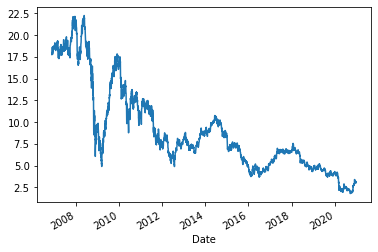

In [48]:
ruta = '/content/drive/MyDrive/proyectos data/FullData.csv'
# tmp

"""
data = 0
open = 1
high = 2
low = 4
close = 5
adjClose = 6
colume = 7
"""
variables_a_predecir = ['open','high','low','volume']
variables_extra_df = ['kdjk']

predictores = variables_a_predecir + variables_extra_df

principal_target = 'close'
fecha = 'Date'
len_x = 100
len_y = 1

data, x_train , y_train , x_test, y_test = cargarDatos(ruta, principal_target, fecha, len_x, len_y, variables_a_predecir,predictores) #ejecutamos el metodo cargar datos


Creamos el modelo

In [49]:
model = Sequential() #https://keras.io/guides/sequential_model/
model.add(LSTM(50, input_shape=(None,x_train.shape[2]), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2,  return_sequences=True))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(variables_a_predecir) + 1 , activation = "linear")) #https://keras.io/api/layers/core_layers/dense/
model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.MeanSquaredError()])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 50)          11400     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 72,255
Trainable params: 72,255
Non-trainable params: 0
_________________________________________________________________
None


Vemos el shape del train y del test que vamos a utilizar para predecir


In [50]:
print(x_train.shape) 
print(y_train.shape)

(3111, 100, 6)
(3111, 5)


Entrenamos

In [ ]:
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
49/49 [==============================] - 27s 399ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 2/10
49/49 [==============================] - 18s 372ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/10
49/49 [==============================] - 18s 375ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/10
49/49 [==============================] - 18s 373ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/10
49/49 [==============================] - 18s 374ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/10
49/49 [==============================] - 18s 374ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 7/10
49/49 [====

Pruebo con test


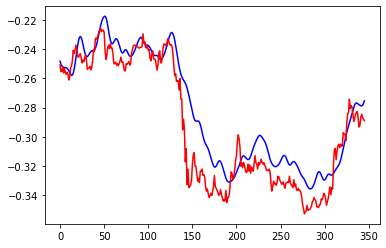

In [ ]:
y = model.predict(x_test)

plt.close() 
plt.plot(y[:,-1:],color = "blue")
plt.plot(y_test[:,-1:],color = "red")


Creo metodo para predecir y retroalimentar


In [ ]:
def dejar_columnas(data, columnas):
  return data[columnas]
#para que este metodo las ultimas columnas que prediga la red neuronal tienen que ser las que no se pueden calcular
#y en el oren dado
variables_importantes = ['open','high','low','volume']
def convertir_np_a_dataframe(np_arr, variables):
  #sel_arr = np.delete(np_arr, np.s_[:np_arr.shape[1]-len(variables)],1)
  df = pd.DataFrame(np_arr, columns=variables)
  return df

'''
creamos un metdodo para predecir es es que se usara finalmente 
-este metodo te permite especificar el numero de predictores (dias) y el numero de predicciones (dias) 
-te permite establecer las variables importantes (las que va a predecir la rede neuronal)
-tiene un flag, (0) realiza el calculo de variables segundarias con los dias especificados en num_predictores
(1) realiza el calculo de variables segundarias con los dias especificados en tam_calculo
-el calculo de variables segundarias esta en otro notebook hay que implementarlo en el metodo.
'''
target = ['close']
def generarPredicciones(data, num_predictores, num_predicciones, variables_importantes):

  #cargamos data y dejo las columnas que me interesan
  data = dejar_columnas(data, variables_importantes+variables_extra_df+target)
  print(np.array(data).shape)
  #creo variables auxiliares
  x = data
  y = []

  #convierto a np array
  x = np.array(x)
  dataNP = x.copy()


  #meto en y nones para poder pintarlo bien
  for i in range(num_predicciones):
    print("entrada",x)
    a_predecir = np.expand_dims(x[-num_predictores:,:], axis = 0) #preparo x para predecir
    np_predicho = model.predict(a_predecir) #predigo
    print("predicho",np_predicho)
    
    y.append(np_predicho[:,:])
    dataF_predicho = convertir_np_a_dataframe(np_predicho, variables_importantes + target) #convertir a datafrme la prediccion
    dataF_X = convertir_np_a_dataframe(x, variables_importantes + variables_extra_df + target) #convertir x a dataframe
    dataF_X = dejar_columnas(dataF_X, variables_importantes + target)#elimino las columnas extras para concatenar
    dataF_X = pd.concat([dataF_X,dataF_predicho]) #concateno x con la prediccion
    #creacion de variables
    tempStock = StockDataFrame.retype(dataF_X)#convierto la concatenacion a un dataframe especial
    for var_df in variables_extra_df:#genero las variables nuevas con la x ya concatenada
      tempStock.get(var_df)
    tempStock[variables_extra_df] = (tempStock[variables_extra_df] - tempStock[variables_extra_df].mean(axis = 0)) / (tempStock[variables_extra_df].max(axis = 0) - tempStock[variables_extra_df].min(axis = 0))
    tempStock = dejar_columnas(tempStock, variables_importantes + variables_extra_df + target)#dejo las columnas que me interesan
    x = np.array(tempStock)
  return x[-num_predicciones:,:]



Predecimos con retroalimenacion varios dias


In [ ]:
atras = 1000
maximos = data.max(axis = 0)
minimos = data.min(axis = 0)
media = data.mean(axis = 0)
data = (data - media) / (maximos -minimos)
print(data.shape[0]-atras)
print(data.iloc[:data.shape[0]-atras,])
data1 = data.iloc[:data.shape[0]-atras,]
y = generarPredicciones(data1, 2000, 700, variables_importantes)

Se han truncado las últimas 5000 líneas del flujo de salida.
entrada [[ 0.43259595  0.42788937  0.43845639 -0.07612562  0.03163411  0.42792043]
 [ 0.43602731  0.43130399  0.43796108 -0.06807863  0.01041397  0.43574438]
 [ 0.43063522  0.42984054  0.43895169 -0.07375849  0.0290623   0.43232141]
 ...
 [-0.21345018 -0.20930928 -0.20922059  0.01263382 -0.13067485 -0.20977721]
 [-0.21382518 -0.20968193 -0.20957915  0.01267428 -0.1313395  -0.21014115]
 [-0.21419942 -0.21005365 -0.20993714  0.01271319 -0.13200406 -0.21050456]]
predicho [[-0.21457294 -0.21042435 -0.21029456  0.01275064 -0.21086729]]
entrada [[ 0.43259595  0.42788937  0.43845639 -0.07612562  0.03168447  0.42792043]
 [ 0.43602731  0.43130399  0.43796108 -0.06807863  0.01046434  0.43574438]
 [ 0.43063522  0.42984054  0.43895169 -0.07375849  0.02911266  0.43232141]
 ...
 [-0.21382518 -0.20968193 -0.20957915  0.01267428 -0.13128913 -0.21014115]
 [-0.21419942 -0.21005365 -0.20993714  0.01271319 -0.1319537  -0.21050456]
 [-0.21457294 

Pinto predicciones


(3558, 6)
(700, 6)
[[-0.17107102]
 [-0.17919339]
 [-0.17810233]
 [-0.17757118]
 [-0.17754734]
 [-0.17790118]
 [-0.17847843]
 [-0.1791455 ]
 [-0.17981313]
 [-0.18045987]
 [-0.18111672]
 [-0.18180987]
 [-0.18253261]
 [-0.1832515 ]
 [-0.18392514]
 [-0.18452246]
 [-0.18503174]
 [-0.18546058]
 [-0.18583059]
 [-0.1861704 ]
 [-0.18650888]
 [-0.18687041]
 [-0.18727264]
 [-0.18772545]
 [-0.18823151]
 [-0.18878676]
 [-0.18938199]
 [-0.1900041 ]
 [-0.19063856]
 [-0.19127174]
 [-0.1918924 ]
 [-0.19249313]
 [-0.19307028]
 [-0.19362375]
 [-0.19415577]
 [-0.1946698 ]
 [-0.19516988]
 [-0.19565964]
 [-0.19614187]
 [-0.1966183 ]
 [-0.19709001]
 [-0.19755688]
 [-0.19801852]
 [-0.19847418]
 [-0.19892296]
 [-0.19936429]
 [-0.19979779]
 [-0.20022343]
 [-0.20064151]
 [-0.20105267]
 [-0.20145765]
 [-0.20185749]
 [-0.20225306]
 [-0.20264517]
 [-0.20303462]
 [-0.20342195]
 [-0.20380747]
 [-0.20419143]
 [-0.20457394]
 [-0.20495509]
 [-0.20533463]
 [-0.20571262]
 [-0.20608896]
 [-0.20646372]
 [-0.20683676]
 [-0.2

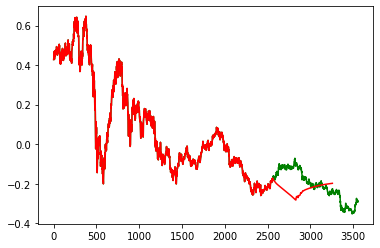

In [ ]:
a = y.copy()

z = dejar_columnas(data, variables_importantes+variables_extra_df+target)
real = np.array(z)

v = np.copy(z)

print(z.shape)
a = np.array(a).squeeze()
print(a.shape)
print(a[:,-1:])
a = np.concatenate((v[:-atras,-1:],a[:,-1:]))

plt.plot(real[:,-1:], color = "green")
plt.plot(a, color = "red")


In [ ]:
z = dejar_columnas(data, variables_importantes+variables_extra_df+target)
z = np.array(z.iloc[:data.shape[0]-500,])
z = (z - z.mean(axis = 0)) / (z.max(axis = 0) - z.min(axis = 0))
print(z[:,:])

[[ 0.42858605  0.4222058   0.43366003 -0.06962349  0.34868208  0.42337188]
 [ 0.43236982  0.42596316  0.43311565 -0.0615765   0.40505321  0.43199721]
 [ 0.42642395  0.42435282  0.43420441 -0.06725637  0.41765697  0.42822364]
 ...
 [-0.28114365 -0.28203471 -0.2783705   0.0067809   0.29269648 -0.27959311]
 [-0.27844094 -0.27827732 -0.27564866  0.01054852  0.35025824 -0.27635859]
 [-0.27411662 -0.27720379 -0.27292682 -0.021323    0.39532372 -0.27474135]]
